In [2]:
!python --version

Python 3.9.6


In [3]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
torch.__version__

'1.13.0+cpu'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Data location

In [5]:
base_dir = 'dataset-vit'
train_dir = os.path.join(base_dir + '/train')
test_dir = os.path.join(base_dir + '/test')

# Create dataset and DataLoader

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
NUM_WORKERS = os.cpu_count()
NUM_WORKERS

8

In [8]:
def create_dataloaders(train_dir, test_dir, transform, batch_size, num_workers=NUM_WORKERS):
    
    #train and test data
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    
    #class names
    class_names = train_data.classes
    
    train_dataloader = DataLoader(train_data, batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    test_dataloader = DataLoader(test_data, batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    
    return train_dataloader, test_dataloader, class_names
    
    

In [9]:
# Create image size and transform
IMG_SIZE = 128
manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [10]:
# Set batch size
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir, test_dir, manual_transform, BATCH_SIZE)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1bb00e0ca60>,
 ['parasitized', 'uninfected'])

## Visualize

In [11]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
print(image.shape, label)

torch.Size([3, 128, 128]) tensor(0)


In [12]:
# label_batch

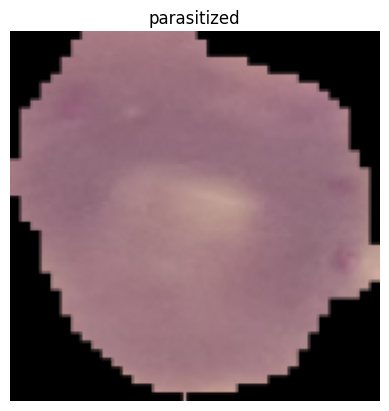

In [13]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

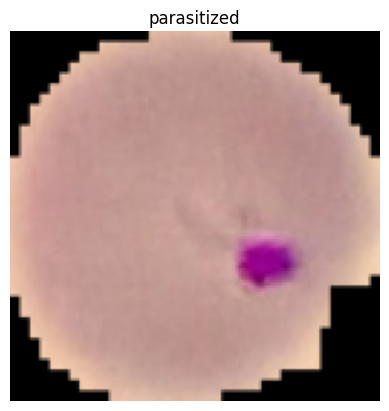

In [14]:
image, label = image_batch[2], label_batch[2]
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [15]:
label_batch

tensor([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 1])

<h1 style="color:red; font-size:30px">It's show time</h1>

# Patch Embedding

In [16]:
"""
nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, 
          groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
torch.nn.Flatten(start_dim=1, end_dim=-1)       
"""

"\nnn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, \n          groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)\ntorch.nn.Flatten(start_dim=1, end_dim=-1)       \n"

In [17]:
import torch.nn as nn
import torchvision

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, 
                                 kernel_size=patch_size, stride=patch_size, padding=0)
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Image size needs to divisible by patch_size {patch_size}"
        x_patched = self.patcher(x)
        x_flatten = self.flatten(x_patched)
        return x_flatten.permute(0,2,1)

## Patch embedding ready?

In [24]:
patch_size = 16
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)
patch_embedded_image = patchify(image.unsqueeze(0))
patch_embedded_image.shape

torch.Size([1, 64, 768])

In [19]:
image.unsqueeze(0).shape

torch.Size([1, 3, 128, 128])

# start from 18:25 